In [14]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor as tt

import scanpy as sc
import collections

In [15]:
import anndata
from collections import namedtuple
from utils import *
from noise_model import Noise_Model

from sklearn.decomposition import PCA
from torch_losses import *


remember you can close sections and subsections that you are not interested in

# Loading data

Input is the h5ad it has alrady ONLY hepatocytes

In [16]:
adatas = {"Tomaz": sc.read_h5ad("data/130723_data_hepatocytes.h5ad")}
data = anndata.concat(adatas, label="dataset", join="inner")
sample_names = data.obs["orig.ident"]

# removing the bad replicate
remove = "scRNA_Seq_Tomaz_220531-01-M-ZT22-H-lib_1-129S"
remove_mask = np.invert(sample_names == remove)

# update data and sample list after the removal of the sample
data = data[remove_mask, :]

# filter mitochoncdrial genes
genes_mito = [s.startswith("mt-") for s in data.var.index]
genes_Mup = [s.startswith("Mup") for s in data.var.index]
genes_keep = np.logical_not(np.logical_or(genes_mito, genes_Mup))
# cut out cells with an unusual number of reads + too low mito content
cells_keep = np.logical_and(data.obs["nCount_RNA"] < 15000, data.obs["percent.mt"] > 3)

data = data[cells_keep, genes_keep]
data


View of AnnData object with n_obs × n_vars = 20080 × 18742
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.intron', 'Sex', 'ZT', 'Variables', 'percent.mt', 'percent.caspase', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'seurat_clusters', 'integrated_snn_res.0.5', 'dataset'
    obsm: 'X_pca', 'X_tsne'

In [17]:
# #make design matrix: number of cells x number of samples
sample_names = data.obs["orig.ident"]
sample_names_uniq = np.unique(data.obs["orig.ident"])
sample_annot = [
    [i] + s.split("_")[3].split("-")[0:4] for i, s in enumerate(sample_names_uniq)
]
sample_annot = np.array(sample_annot)

In [18]:
# design matrix is torch.tensor as it is used in pyro
sample_id = np.zeros(data.n_obs, dtype=np.int64)
for i, s in enumerate(sample_names_uniq):
    sample_id[sample_names == s] = i
design_matrix = make_design_matrix(torch.tensor(sample_id, dtype=torch.int64))
data.obs["sample_id"] = sample_id

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_70557/1821571652.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs["sample_id"] = sample_id


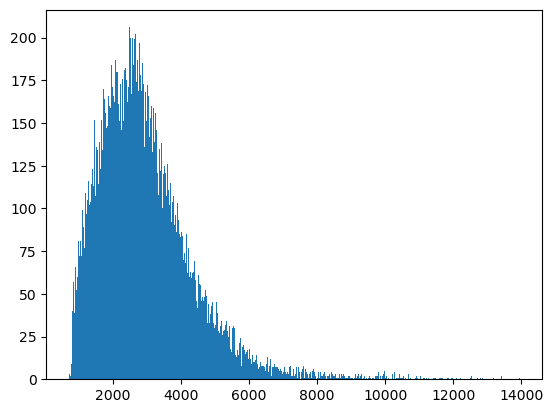

In [19]:
# normalize each sample
data.layers["n_cg"] = data.X.toarray()
data.layers["f_cg"] = data.layers["n_cg"].copy()
nc = np.zeros(data.n_obs)
for s in np.unique(sample_id):
    idx = sample_id == s
    tmp = data.layers["n_cg"][idx, :].sum(axis=1)
    nc[idx] = tmp
    data.layers["f_cg"][idx, :] = (
        data.layers["f_cg"][idx, :] / tmp[:, None]
    )  # normalization!
data.obs["n_c"] = nc
plt.hist(data.obs["n_c"], bins=500)
plt.show()

In [20]:
def gene_index(data, gene):
    return np.where(gene == data.var.index)[0][0]


# Genome subselection

We subselct a smaller part of the genome before looking for new marker genes.

In [21]:
names = np.array(data.var.index)

In [22]:
# from Hildebrandt 2021 + our genes
central = [
    "Oat",
    "Cyp2e1",
    "Lect2",
    "Cyp2c37",
    "Gulo",
    "Cyp2a5",
    "Glul",
    "Aldh1a1",
    "Cyp1a2",
    "Slc22a1",
    "Slc1a2",
]
portal = ["Pck1", "Aldh1b1", "Ctsc", "Sds", "Hal", "Hsd17b13", "Cyp2f2"]

genes = central + portal
data_pyro = data[:, genes]

# filter genes for the second part of the training
sums = data.layers["n_cg"].sum(axis=0)

In [23]:
genome_z_mean = data_pyro[:, :].layers["f_cg"].mean(axis=0)
genome_z_var = data_pyro[:, :].layers["f_cg"].var(axis=0)
genome_z_std = data_pyro[:, :].layers["f_cg"].std(axis=0)
genome_z_CV = genome_z_std / genome_z_mean


for i in range(len(genes)):
    print(genes[i], genome_z_CV[i], genome_z_mean[i])

genome_z_CV.mean()

Oat 2.0439506 0.00015482893
Cyp2e1 0.98066014 0.0037494728
Lect2 1.654552 0.00019455365
Cyp2c37 1.910242 0.0001856216
Gulo 1.6271069 0.00024266877
Cyp2a5 1.3086879 0.0008189971
Glul 2.8030624 0.00018922414
Aldh1a1 1.189998 0.0005807614
Cyp1a2 1.5167239 0.00037138263
Slc22a1 1.4793365 0.00027316564
Slc1a2 5.8941593 4.3037562e-05
Pck1 0.8731482 0.0009874824
Aldh1b1 2.699865 6.164123e-05
Ctsc 3.0557084 5.2425206e-05
Sds 1.7693318 0.00020710856
Hal 1.2315301 0.00043113052
Hsd17b13 1.0300505 0.0006106498
Cyp2f2 1.2393888 0.00090270565


ArrayView(1.9059724, dtype=float32)

In [24]:
# most expressed genes based on sum of normalized counts
genome_mean = data[:, :].layers["f_cg"].mean(axis=0)
genome_var = data[:, :].layers["f_cg"].var(axis=0)
genome_std = data[:, :].layers["f_cg"].std(axis=0)
genome_CV = genome_std / genome_mean


# getting rid of nan values
nan_mask = np.isnan(genome_CV)
not_nan = np.logical_not(nan_mask)
genome_CV[not_nan]

mask_m = genome_mean > 0.00001
# intersecating this mask with the nan mask
mask_m = np.logical_and(mask_m, not_nan)

print(genome_CV[not_nan].mean())

24.97287


/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_70557/901745935.py:5: RuntimeWarning: invalid value encountered in divide
  genome_CV = genome_std / genome_mean


In [25]:
# plt.figure(figsize=(10,10))
# plt.scatter(genome_mean[not_nan], genome_var[not_nan], s=1, label='all genes')
# plt.scatter(genome_z_mean, genome_z_var, s=10, label='zonated genes')
# plt.xscale('log')
# plt.xlabel('mean')
# plt.ylabel('var')
# plt.ylim(-0.00001, 0.0001)
# plt.xlim(0.00001, 0.01)
# plt.legend()


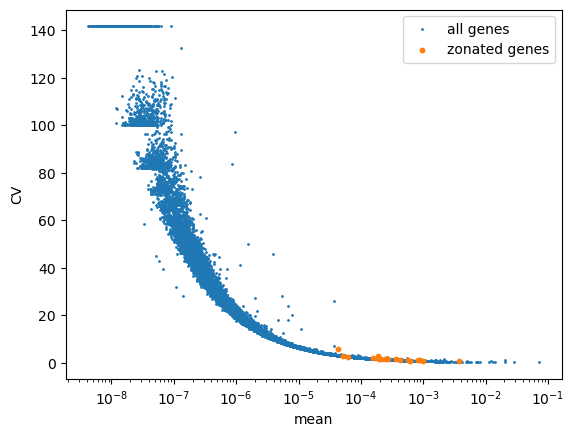

In [26]:
plt.scatter(genome_mean[not_nan], genome_CV[not_nan], s=1, label="all genes")
plt.scatter(genome_z_mean, genome_z_CV, s=10, label="zonated genes")
plt.xscale("log")
plt.xlabel("mean")
plt.ylabel("CV")
plt.legend()

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_70557/482993124.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10)


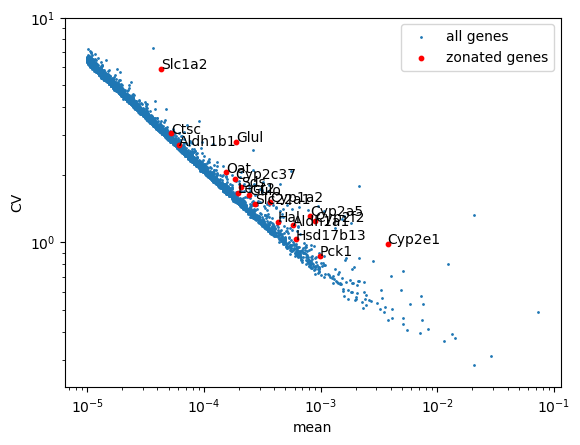

In [27]:
plt.scatter(genome_mean[mask_m], genome_CV[mask_m], s=1, label="all genes")
plt.scatter(genome_z_mean, genome_z_CV, s=10, label="zonated genes", c="red")


# now i wanna annotate the genes
for i in range(len(genes)):
    plt.annotate(genes[i], (genome_z_mean[i], genome_z_CV[i]))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("mean")
plt.ylabel("CV")
# plt.xlim(0.00001, 1)
plt.ylim(0, 10)
plt.legend()

-0.45768318013683695 -1.491959097293329
-0.45768318013683695 -1.491959097293329


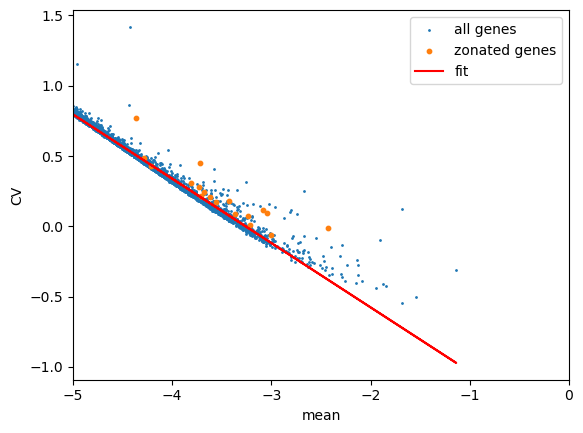

In [28]:
# i wanna take the genes with mean>0.00001 and fit a line ub the log-log plot mean vs CV
# fit a line to the data
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log10(genome_mean[mask_m]), np.log10(genome_CV[mask_m])
)
print(slope, intercept)

slope2, intercept2, r_value, p_value, std_err = stats.linregress(
    genome_mean[mask_m], genome_CV[mask_m]
)
print(slope, intercept)

# plot the line
plt.scatter(
    np.log10(genome_mean[mask_m]), np.log10(genome_CV[mask_m]), s=1, label="all genes"
)
plt.scatter(np.log10(genome_z_mean), np.log10(genome_z_CV), s=10, label="zonated genes")
plt.plot(
    np.log10(genome_mean[mask_m]),
    slope * np.log10(genome_mean[mask_m]) + intercept,
    label="fit",
    c="r",
)

plt.xlim(-5, 0)
plt.xlabel("mean")
plt.ylabel("CV")
plt.legend()

In [29]:
# take exponential base 10 of 2


/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_70557/25563631.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10)


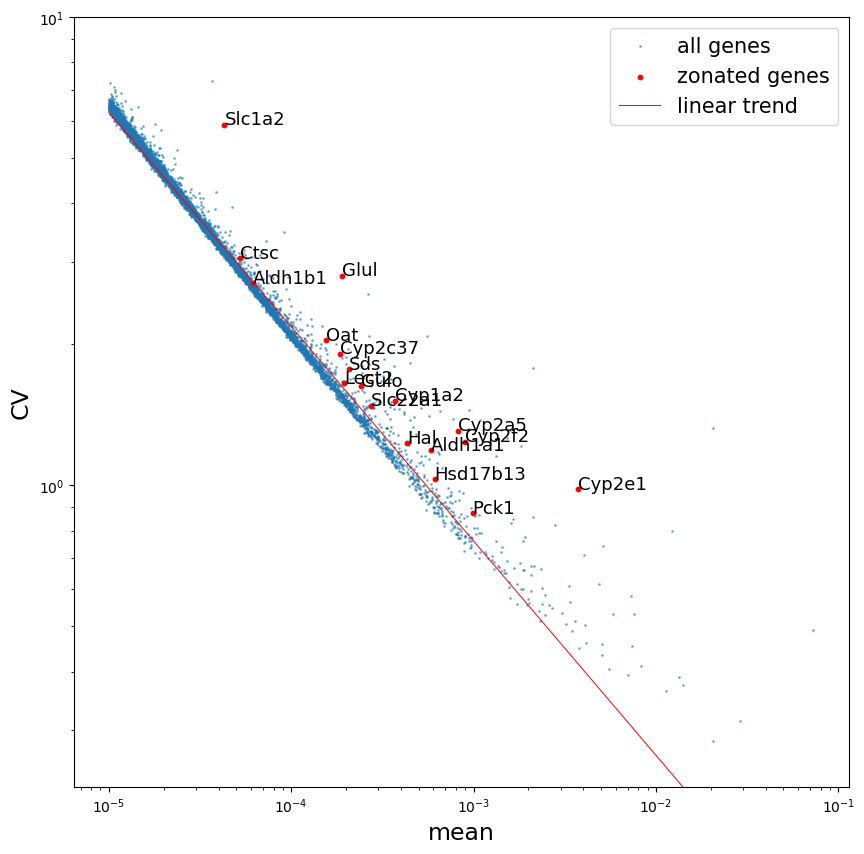

In [32]:
plt.figure(figsize=(10, 10))

plt.scatter(genome_mean[mask_m], genome_CV[mask_m], s=1, label="all genes", alpha=0.5)
plt.scatter(genome_z_mean, genome_z_CV, s=10, label="zonated genes", c="red")

# now i wanna annotate the genes
for i in range(len(genes)):
    #set font size
    plt.annotate(genes[i], (genome_z_mean[i], genome_z_CV[i]) , fontsize=13)
    # change font size

plt.xscale("log")
plt.yscale("log")

plt.xlabel("mean", fontsize=17)
plt.ylabel("CV" , fontsize=17)
# plt.xlim(0.00001, 1)
plt.ylim(0, 10)

# mean linspace
mu_ = np.linspace(1e-5, 3e-2, 200)
plt.plot(
    mu_,
    10 ** (slope * np.log10(mu_) + intercept) ,
    label="linear trend",
    c="r",
    # line width
    lw=0.7,
)

# legend bigger than default
plt.legend(fontsize=15)


In [33]:
# now i wanna compute the residuals of these genes, and take the ones with the highest residuals
residuals = np.log10(genome_CV[mask_m]) - (
    slope * np.log10(genome_mean[mask_m]) + intercept
)
residuals_z = np.log10(genome_z_CV) - (slope * np.log10(genome_z_mean) + intercept)

# print the residuals for the zonated gens next the the gene name
for i in range(len(genes)):
    print(genes[i], residuals_z[i])

Oat 0.058588773
Cyp2e1 0.37312463
Lect2 0.012195259
Cyp2c37 0.06526151
Gulo 0.048856825
Cyp2a5 0.19605651
Glul 0.23562667
Aldh1a1 0.086441614
Cyp1a2 0.10293065
Slc22a1 0.0310383
Slc1a2 0.26406646
Pck1 0.05749369
Aldh1b1 -0.0036039948
Ctsc 0.017976493
Sds 0.05375421
Hal 0.04212115
Hsd17b13 0.033728853
Cyp2f2 0.19177136


In [34]:
#comparing the mean of residuals of the zonated genes with the mean of the residuals of all genes
print(residuals_z.mean())
print(residuals.mean())
print('zonated genes have a million times higher residuals than all genes!!!!')

0.10374606
8.849802e-08
zonated genes have a million times higher residuals than all genes!!!!


In [35]:
names2=names[mask_m]
vldlr=np.where(names2=='Vldlr')[0][0]
ordered=residuals.argsort()


best=ordered[-400:]
small_list=names2[best]

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_70557/2731759595.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10)


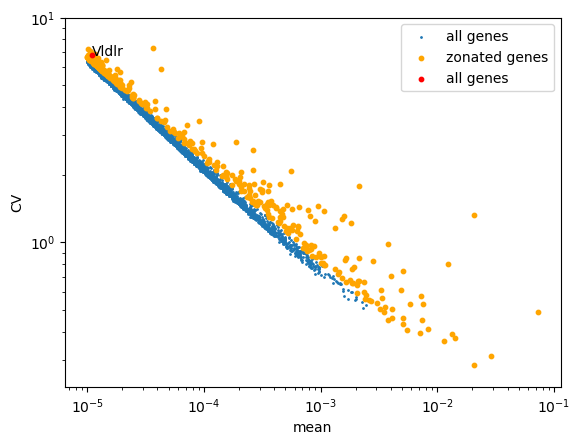

In [36]:
plt.scatter(genome_mean[mask_m], genome_CV[mask_m], s=1, label="all genes")
# plt.scatter(genome_z_mean, genome_z_CV, s=10, label="zonated genes", c="red")
plt.scatter(genome_mean[mask_m][best], genome_CV[mask_m][best], s=10, label="zonated genes", c="orange")


# now i wanna annotate the genes
# for i in range(len(genes)):
#     plt.annotate(genes[i], (genome_z_mean[i], genome_z_CV[i]))

#plot Vldlr single point with annotation
plt.scatter(genome_mean[mask_m][vldlr], genome_CV[mask_m][vldlr], s=10, label="all genes", c='red')
plt.annotate('Vldlr', (genome_mean[mask_m][vldlr], genome_CV[mask_m][vldlr]))


plt.xscale("log")
plt.yscale("log")
plt.xlabel("mean")
plt.ylabel("CV")
# plt.xlim(0.00001, 1)
plt.ylim(0, 10)
plt.legend()

In [37]:
#SUMM OF ALL COUNT OF vldlr
data[:, 'Vldlr'].layers["n_cg"].sum()

ArrayView(563., dtype=float32)

# fitting the latent variables

In [38]:
x_pd = pd.read_csv("coeff_values/small_set_x.txt", sep=",")
x_pyro = np.array(x_pd.values[:, 1]).astype(float)

In [39]:
x_pyro = np.array(x_pd.values[:, 1]).astype(float)
x_pyro = tt(x_pyro, dtype=float)
x_pyro.shape

torch.Size([20080])

## Training pt 2, expanding gene list

In [45]:
data_pyro2 = data[:, small_list]

In [ ]:
DATA2 = data_pyro2[:, :].layers["n_cg"]
DATA2 = torch.tensor(DATA2)

NC = DATA2.shape[0]
NG2 = DATA2.shape[1]
NS = design_matrix.shape[1]

# now the procedure we did earlier on PC1 ensures that theres is one entrie=1 and one entry=0, they both create problems when we do the reparametrization
# here also the slope coefficient is mouse dependent

A1_ = torch.randn(NG2, dtype=float)
A1_ = A1_.repeat(NS, 1)
A1_.requires_grad = True

A0_ = torch.randn(NG2, dtype=float)
A0_ = A0_.repeat(NS, 1)
A0_.requires_grad = True

DISP = tt(0.2, requires_grad=True)

In [ ]:
NG2 = data_pyro2.shape[1]

log_n_UMI = torch.log(tt(data.obs["n_c"].values.astype(np.float32)))
dm = tt(design_matrix, dtype=float)
clamp = gene_index(data_pyro2, "Cyp2e1")
fix = tt(1.0).detach()
mask = torch.eye(NG2, dtype=float)
mask[clamp, clamp] = 0

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_48784/3111584564.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = tt(design_matrix, dtype=float)


In [ ]:
# the loss is defined here, extremely simple
mp = dict(
    log_n_UMI=log_n_UMI,
    clamp=clamp,
    dm=dm,
    fix=fix,
    mask=mask,
    cutoff=50,
)
MyTuple = namedtuple("param", mp)
MP = MyTuple(**mp)


In [ ]:
# we do not optimize over x here, we seek only the coefficients
def loss_coeff_only_batch(x, a0, a1, disp, batch_size, mp, DATA):
    NC = DATA.shape[0]

    idx = torch.randperm(DATA.shape[0])[:batch_size]
    y = (
        mp.log_n_UMI[idx, None]
        + torch.matmul(mp.dm[idx, :], a0)
        + torch.matmul(mp.dm[idx, :], a1) * x[idx, None]
    )
    alpha = disp.exp()

    y = mp.cutoff * torch.tanh(y / mp.cutoff)
    lmbda = torch.exp(y)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)
    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )
    return -NB.log_prob(DATA[idx, :]).sum() * (
        NC / batch_size
    )  # correct the likelihood rescaling

In [ ]:
loss_coeff_only_batch(x_pyro, A0_, A1_, DISP, 64, MP, DATA2)

tensor(55051861.0080, dtype=torch.float64, grad_fn=<MulBackward0>)

In [ ]:
losses = []
optimizer = torch.optim.Adam([A0_, A1_, DISP], lr=0.001)
n_iter1 = 25000
batch_size = 128

#with a batch this size, it takes 313 ietr to see all cells
print(NC/64)

#every cell in avarage is seen this number of times
print(n_iter1/(NC/64))

313.75
79.6812749003984


In [ ]:

plotting_data = collections.defaultdict(list)

##Optimize the variable to minimize the loss
for step in range(n_iter1):
    optimizer.zero_grad()  # zero the gradients

    output = loss_coeff_only_batch(x_pyro, A0_, A1_, DISP, 64, MP, DATA2)
    output.backward()

    optimizer.step()
    losses.append(output.detach().numpy())

7427524.852484807


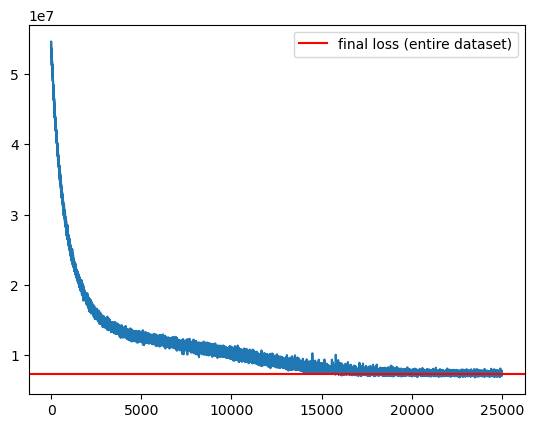

In [ ]:
n_iter = n_iter1  # +n_iter2
losses = np.array(losses)
itx = np.linspace(1, n_iter, n_iter)

start_from = 000
loss_1 = loss_coeff_only_batch(x_pyro, A0_, A1_, DISP, NC, MP, DATA2).detach().numpy()
plt.plot(itx[start_from:], losses[start_from - n_iter :])
plt.axhline(y=loss_1, color="red", linestyle="-", label="final loss (entire dataset)")
plt.legend()
print(loss_1)


In [ ]:
# losses2 = []
# optimizer = torch.optim.Adam([A0_, A1_, DISP], lr=0.001)
# n_iter2 = 1000
# batch_size = NC
# # Optimize the variable to minimize the loss
# for step in range(n_iter2):
#     optimizer.zero_grad()  # zero the gradients
#     output = loss_coeff_only_batch(x_pyro, A0_, A1_, DISP, NC, MP, DATA2)

#     output.backward()  # compute the gradients
#     optimizer.step()  # update the variable
#     losses2.append(output.detach().numpy())


In [ ]:
# losses2 = np.array(losses2)
# itx = np.linspace(1, losses2.shape[0], losses2.shape[0])

# start_from = 00
# loss_2 = loss_coeff_only_batch(x_pyro, A0_, A1_, DISP, NC, MP, DATA2).detach().numpy()
# plt.plot(itx[start_from:], losses2[start_from:])
# plt.axhline(y=loss_2, color="red", linestyle="-", label="final loss (entire dataset)")
# plt.legend()
# print(loss_2)


# gene selction analysis

In [12]:
hild_g=set(genes)

In [46]:
a0_genome=A0_.clone().detach().numpy()
a1_genome=A1_.clone().detach().numpy()
disp=np.exp(DISP.detach().numpy())
disp


NameError: name 'A0_' is not defined

In [42]:
# saving the precious fitted values
# df_a0 = pd.DataFrame(a0_genome, index=sample_names_uniq, columns=data_pyro2.var.index)
# df_a1 = pd.DataFrame(a1_genome, index=sample_names_uniq, columns=data_pyro2.var.index)

# df_a0.to_csv("coeff_values/gene_selection/torch_final_a0.txt", sep=",")
# df_a1.to_csv("coeff_values/gene_selection/torch_final_a1.txt", sep=",")


# loading values
a0_pd = pd.read_csv(
    "coeff_values/gene_selection/torch_final_a0.txt", sep=","
)
a0_genome = np.array(a0_pd.values[:, 1:]).astype(float)

a1_pd = pd.read_csv(
    "coeff_values/gene_selection/torch_final_a1.txt", sep=","
)
a1_genome = np.array(a1_pd.values[:, 1:]).astype(float)
a1_genome

array([[ 0.50112466,  1.31166765,  0.78384053, ..., -0.16001328,
         0.0108803 ,  0.33043241],
       [ 1.01314664,  0.99441493,  0.97046817, ..., -0.24333849,
        -0.239524  ,  0.63424948],
       [ 0.38361078,  0.78463639,  0.72139368, ..., -0.20736971,
         0.02680313,  0.52604344],
       ...,
       [ 0.61670565,  1.42965996,  0.70308256, ..., -0.0917016 ,
        -0.01648178,  1.40676965],
       [ 0.34400751,  0.63350776,  0.53618001, ..., -0.32627373,
        -0.00964072,  1.4606752 ],
       [ 0.40866222,  1.17922707,  0.59889341, ..., -0.21469902,
         0.01898015,  0.60185843]])

In [47]:
names = data_pyro2.var.index

a1_means = a1_genome.mean(axis=0)
a0_means = a0_genome.mean(axis=0)

a1_std = a1_genome.std(axis=0)
a0_std = a0_genome.std(axis=0)

a1_r = a1_means / a1_std
gene_m = data_pyro2.layers["f_cg"].mean(axis=0)

In [48]:
# mask_right=np.array(np.logical_and( a1_means>0.25 , a1_std<4.),dtype=bool)

mask_right = (
    (a1_r > 5.0).astype(int) & (a1_std < 4).astype(int) & (a0_means > -10).astype(int)
).astype(bool)
mask_left = (
    (a1_r < -2.3).astype(int) & (a1_std < 4).astype(int) & (a0_means > -10).astype(int)
).astype(bool)

new_set_central = set(names[mask_right])
new_set_portal = set(names[mask_left])

new_set = set(names[mask_left]) | set(names[mask_right])

print(mask_right.sum(), mask_left.sum())
print(new_set_central)
print(new_set_portal)

19 17
{'Slco1b2', 'Gm30117', 'Slc1a2', 'Aldh1a1', 'Cyp2c50', 'Cyp1a2', 'Glul', 'Slc22a1', 'Mgst1', 'Airn', 'Cyp7a1', 'Lhpp', 'Pon1', 'Rnase4', 'Gulo', 'Cyp2c54', 'Lgr5', 'Cyp2e1', 'Oat'}
{'Apoa4', 'Serpinc1', 'Alb', 'Hal', 'Hpx', 'Hsd17b6', 'Apoc2', 'Pigr', 'Itih4', 'Pck1', 'Hsd17b13', 'Apoc3', 'Gc', 'Sds', 'Cyp2f2', 'Serpina1b', 'Serpina1d'}


In [66]:
final_central=set(central) | new_set_central
final_portal=set(portal) | new_set_portal

print(final_central)
print(final_portal)


# do set subtraction to find the genes that are not in the initial set
new_genes_c = new_set_central - set(central)
new_genes_p = new_set_portal - set(portal)


{'Glul', 'Slc22a1', 'Mgst1', 'Airn', 'Slco1b2', 'Cyp7a1', 'Cyp2c37', 'Gm30117', 'Lhpp', 'Pon1', 'Cyp2a5', 'Rnase4', 'Gulo', 'Slc1a2', 'Cyp2c54', 'Lgr5', 'Lect2', 'Cyp2e1', 'Aldh1a1', 'Cyp2c50', 'Cyp1a2', 'Oat'}
{'Serpinc1', 'Alb', 'Hal', 'Hsd17b6', 'Apoc2', 'Itih4', 'Gc', 'Cyp2f2', 'Pck1', 'Serpina1b', 'Serpina1d', 'Apoa4', 'Aldh1b1', 'Hpx', 'Pigr', 'Ctsc', 'Hsd17b13', 'Apoc3', 'Sds'}


{'Alb',
 'Apoa4',
 'Apoc2',
 'Apoc3',
 'Gc',
 'Hpx',
 'Hsd17b6',
 'Itih4',
 'Pigr',
 'Serpina1b',
 'Serpina1d',
 'Serpinc1'}

In [50]:
final_set = new_set | hild_g
final_set

{'Airn',
 'Alb',
 'Aldh1a1',
 'Aldh1b1',
 'Apoa4',
 'Apoc2',
 'Apoc3',
 'Ctsc',
 'Cyp1a2',
 'Cyp2a5',
 'Cyp2c37',
 'Cyp2c50',
 'Cyp2c54',
 'Cyp2e1',
 'Cyp2f2',
 'Cyp7a1',
 'Gc',
 'Glul',
 'Gm30117',
 'Gulo',
 'Hal',
 'Hpx',
 'Hsd17b13',
 'Hsd17b6',
 'Itih4',
 'Lect2',
 'Lgr5',
 'Lhpp',
 'Mgst1',
 'Oat',
 'Pck1',
 'Pigr',
 'Pon1',
 'Rnase4',
 'Sds',
 'Serpina1b',
 'Serpina1d',
 'Serpinc1',
 'Slc1a2',
 'Slc22a1',
 'Slco1b2'}

## filtering with slope and slope variance

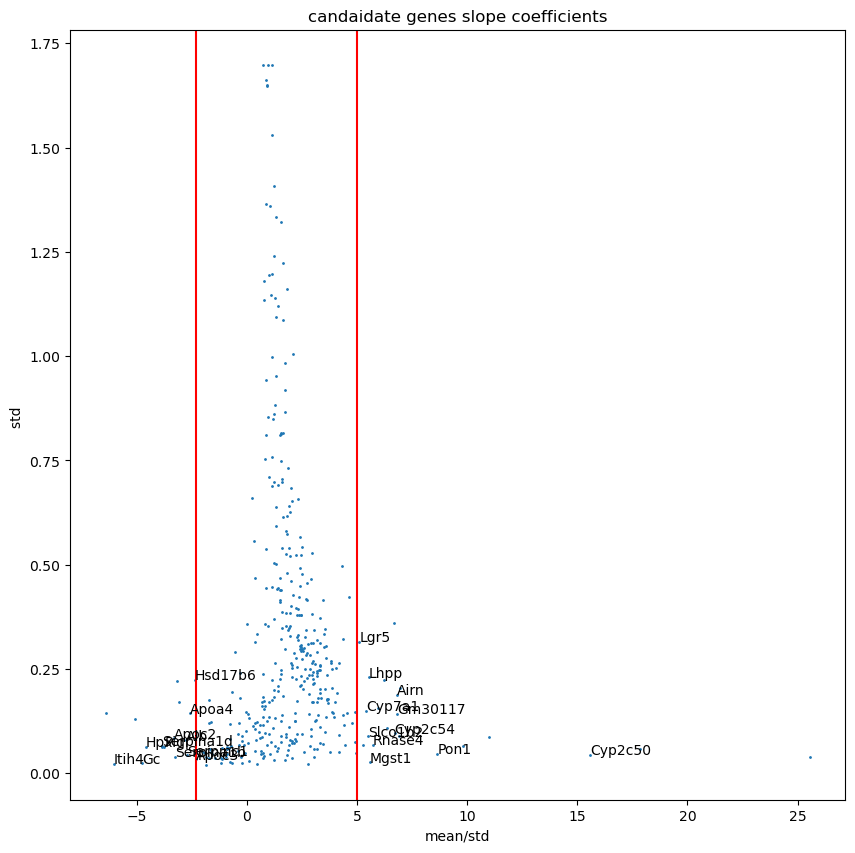

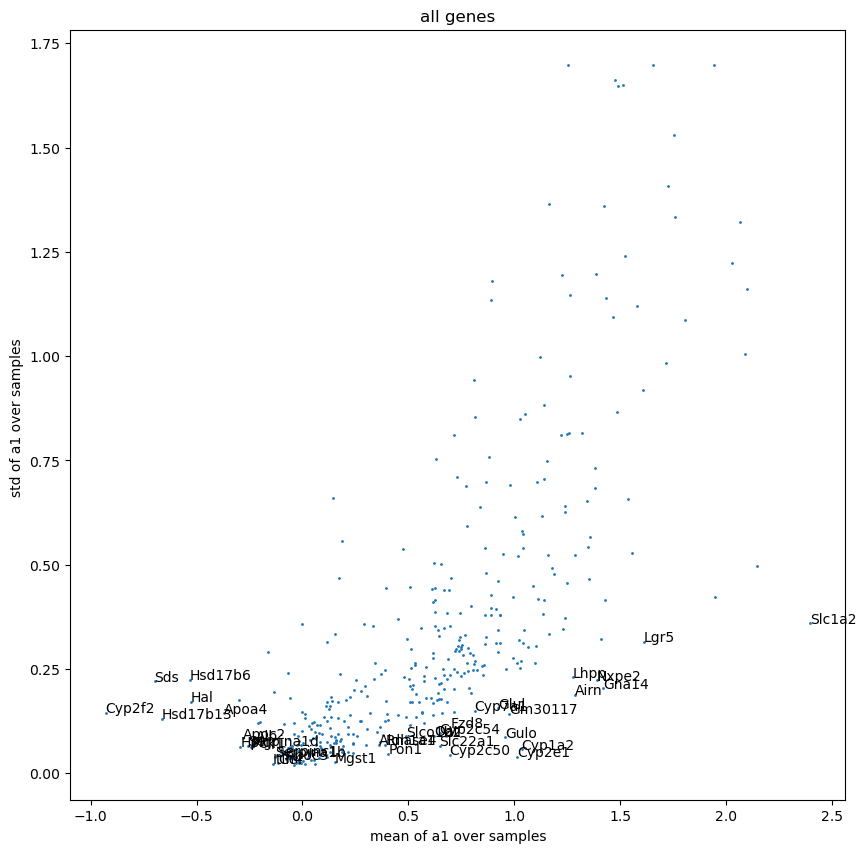

Text(0, 0.5, 'signal to noise ')

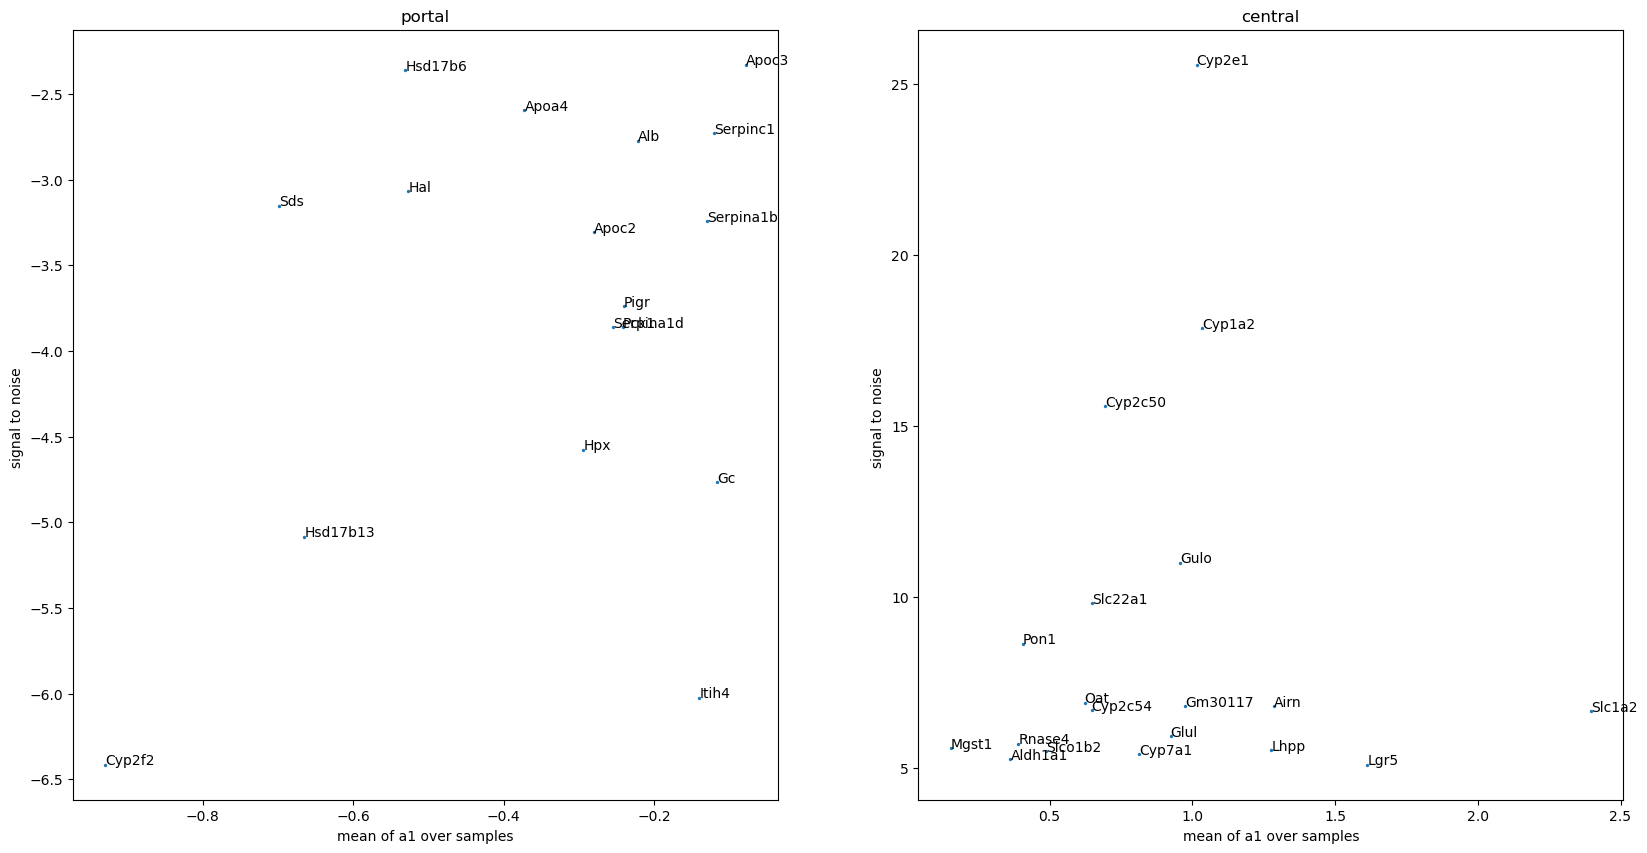

In [68]:

plt.figure(figsize=(10, 10))
plt.scatter(a1_r, a1_std, s=1)
# plt.xlim(left=0,right=0.01)
plt.title("candaidate genes slope coefficients")
for i, txt in enumerate(names):
    if (a1_r[i] > 5) or (a1_r[i] < -2.3):
        if txt in new_genes_c or txt in new_genes_p:
            plt.annotate(txt, (a1_r[i], a1_std[i]), fontsize=10, )

# plot vertical lines at the cutoffs
plt.axvline(x=5, color="red", linestyle="-")
plt.axvline(x=-2.3, color="red", linestyle="-")
plt.xlabel("mean/std")
plt.ylabel("std ")
plt.show()



plt.figure(figsize=(10, 10))
plt.scatter(a1_means, a1_std, s=1)
# plt.xlim(left=0,right=0.01)
plt.title("all genes")
for i, txt in enumerate(names):
    # plot nmes only otside of the cutoffs
    if (a1_r[i] > 5) or (a1_r[i] < -2.3):
        plt.annotate(txt, (a1_means[i], a1_std[i]), fontsize=10)
plt.xlabel("mean of a1 over samples")
plt.ylabel("std of a1 over samples ")
plt.show()

# plt.figure(figsize=(20, 10))
# plt.subplot(121)
# for i, txt in enumerate(names[mask_left]):
#     plt.annotate(txt, (a1_means[mask_left][i], a1_std[mask_left][i]), fontsize=10)
# plt.scatter(a1_means[mask_left], a1_std[mask_left], s=2)
# plt.title("portal")
# plt.xlabel("mean of a1 over samples")
# plt.ylabel("std of a1 over samples ")
# plt.subplot(122)

# for i, txt in enumerate(names[mask_right]):
#     plt.annotate(txt, (a1_means[mask_right][i], a1_std[mask_right][i]), fontsize=10)
# plt.scatter(a1_means[mask_right], a1_std[mask_right], s=2)
# plt.title("central")
# plt.xlabel("mean of a1 over samples")
# plt.ylabel("std of a1 over samples ")


plt.figure(figsize=(20, 10))
plt.subplot(121)
for i, txt in enumerate(names[mask_left]):
    # annotations not overlapping
    plt.annotate(txt, (a1_means[mask_left][i], a1_r[mask_left][i]), fontsize=10)
plt.scatter(a1_means[mask_left], a1_r[mask_left], s=2)
plt.title("portal")
plt.xlabel("mean of a1 over samples")
plt.ylabel("signal to noise ")
plt.subplot(122)

for i, txt in enumerate(names[mask_right]):
    plt.annotate(txt, (a1_means[mask_right][i], a1_r[mask_right][i]), fontsize=10)
plt.scatter(a1_means[mask_right], a1_r[mask_right], s=2)
plt.title("central")
plt.xlabel("mean of a1 over samples")
plt.ylabel("signal to noise ")